# Book Cover in Recommender System

### import requirements

In [2]:
import os
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import random
import cv2
import urllib.request

In [2]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [3]:
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.layers import concatenate
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model

### --- classes and functions ---

In [4]:
class NN_models:

    def create_mlp(Self, dim, regress=False):
        # define our MLP network
        model = Sequential()
        model.add(Dense(8, input_dim=dim, activation="relu"))
        model.add(Dense(4, activation="relu"))

        # check to see if the regression node should be added
        if regress:
            model.add(Dense(1, activation="linear"))

        # return our model
        return model

    def create_cnn(Self, height, width, depth, filters=(16, 32, 64), regress=False):
        # initialize the input shape and channel dimension, assuming TensorFlow/channels-last ordering

        filters = np.asarray(filters)
        input_shape = (height, width, depth)
        chanDim = -1

        # define the model input
        inputs = Input(shape=input_shape)

        # loop over the number of filters
        for i in range(filters.shape[0]):
            # if this is the first CONV layer then set the input
            # appropriately
            f = filters[i]
            if i == 0:
                x = inputs

            # CONV => RELU => BN => POOL
            x = Conv2D(f, (3, 3), padding="same")(x)
            x = Activation("relu")(x)
            x = BatchNormalization(axis=chanDim)(x)
            x = MaxPooling2D(pool_size=(2, 2))(x)

        # flatten the volume, then FC => RELU => BN => DROPOUT
        x = Flatten()(x)
        x = Dense(16)(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = Dropout(0.5)(x)

        # apply another FC layer, this one to match the number of nodes
        # coming out of the MLP
        x = Dense(4)(x)
        x = Activation("relu")(x)

        # check to see if the regression node should be added
        if regress:
            x = Dense(1, activation="linear")(x)

        # construct the CNN
        model = Model(inputs, x)

        # return the CNN
        return model

In [48]:
def download_images(df, input_path):
    
    for i in df['isbn'].index:
        file_path_s = input_path + "//" + str(i) + '.jpg'
        url = df.loc[i]['image']
        try:
            urllib.request.urlretrieve(url, file_path_s)
        except: # http 404
            pass


def load_cover_images(df, input_path):
    # initialize our images array
    images = []

    # loop over the indexes of the books
    for i in df['isbn'].index:

        path = input_path + "//" + str(i) + '.jpg'
        #print(path)
        image = cv2.imread(path)
        try:
            outputImage = cv2.resize(image, (32, 32))
        except: # image is empty
            pass
        images.append(outputImage)

    # return our set of images
    return np.array(images)

In [125]:
def create_cover_image_data(train_df, test_df, images, scaling):
    # process and filter data and label per for the CNN

    train_Y = train_df['average_rating']
    test_Y = test_df['average_rating']

    train_images = []
    for j in range(len(train_df['isbn'])):
        train_images.append(images[j - 1])
    test_images = []
    for j in range(len(test_df['isbn'])):
        test_images.append(images[j - 1])

    train_Y = np.asarray(train_Y) / scaling
    test_Y = np.asarray(test_Y) / scaling

    return np.asarray(train_images), train_Y, np.asarray(test_images), test_Y


def create_user_book_data(train_df, test_df, df, scaling):
    # process and filter data and label per for the NN
    train_Y = train_df['average_rating']
    test_Y = test_df['average_rating']

    # Continous data
    cont = ['year', 'pages', 'ratings_count', 'text_reviews_count']
    cs = MinMaxScaler()

    trainCont = cs.fit_transform(train_df[cont])
    testCont = cs.transform(test_df[cont])

    # Categorical data
    categ = ['author', 'title', 'publisher', 'language_code']

    for j in range(len(categ)):
        bin = LabelBinarizer().fit(df[categ[j]])
        if j == 0:
            trainFull = np.hstack([trainCont, bin.transform(train_df[categ[j]])])
            testFull = np.hstack([testCont, bin.transform(test_df[categ[j]])])
        else:
            trainFull = np.hstack([trainFull, bin.transform(train_df[categ[j]])])
            testFull = np.hstack([testFull, bin.transform(test_df[categ[j]])])

    train_Y = np.asarray(train_Y) / scaling
    test_Y = np.asarray(test_Y) / scaling

    return trainFull, train_Y, testFull, test_Y

In [7]:
def split_data(df, split, n):
    allbooks = random.sample(list(df['isbn']), n)
    split_train = np.around(n * split)
    train = df[df['isbn'].isin(allbooks[0:int(split_train) - 1])]
    test = df[df['isbn'].isin(allbooks[int(split_train):n])]

    return test, train

In [56]:
def NN_fit(train_df, train_Y, test_df, test_Y, model):
    # train the model
    print("[INFO] training model...")
    m = model.fit(train_df, train_Y, validation_data=(test_df, test_Y), epochs=25, batch_size=8)

    # make predictions on the testing data
    print("[INFO] predicting book ratings...")
    preds_test = model.predict(test_df)
    preds_train = model.predict(train_df)

    # compute the difference between the *predicted* book rating and the
    # *actual* rating, then compute the percentage difference and
    # the absolute percentage difference
    diff = preds_test.flatten() - test_Y
    percentDiff = (diff / test_Y) * 100
    absPercentDiff = np.abs(percentDiff)

    # compute the mean and standard deviation of the absolute percentage
    # difference
    mean = np.mean(absPercentDiff)
    std = np.std(absPercentDiff)

    return preds_test, preds_train, mean, std, m.history['val_loss']

## --- main ---

### load dataset

In [25]:
df1 = pd.read_csv('../books_agg.csv', index_col=0)
df1.head(3)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating,Location,Age,City,State,Country
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,2.0,0.0,"stockton, california, usa",18.0,stockton,california,usa
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,8.0,5.0,"timmins, ontario, canada",NaN,timmins,ontario,canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,8.0,0.0,"timmins, ontario, canada",NaN,timmins,ontario,canada


In [26]:
df2 = pd.read_csv('../books/GoodReadBooks.csv', error_bad_lines=False)
df2.head(3)

b'Skipping line 3350: expected 12 fields, saw 13\nSkipping line 4704: expected 12 fields, saw 13\nSkipping line 5879: expected 12 fields, saw 13\nSkipping line 8981: expected 12 fields, saw 13\n'


,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic


In [27]:
df = df1.merge(df2, left_on='ISBN', right_on='isbn')
df.shape

(55412, 27)

In [12]:
df_orig = df
df = df.dropna()
df = df.drop_duplicates(subset='isbn')
df.shape

(3382, 27)

In [28]:
df = df[['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher', 
         'Image-URL-S', 'average_rating', 'language_code',
         '  num_pages', 'ratings_count', 'text_reviews_count']]

df.columns = ['isbn', 'title', 'author', 'year', 'publisher',
              'image', 'average_rating', 'language_code',
              'pages', 'ratings_count', 'text_reviews_count']

In [14]:
n_books = len(set(df['isbn']))
print(f'There are {n_books} books in the dataset.')

There are 3382 books in the dataset.


In [31]:
pd.get_dummies(df).shape

(55412, 13794)

### download images

In [5]:
root_path = r'/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn'

In [6]:
if not os.path.isdir(root_path + r'/output'):
    os.mkdir(root_path + r'/output')
save_path = root_path + r'/output'

In [31]:
# download images from web
if not os.path.isdir(root_path + r'/img_s'):
    os.mkdir(root_path + r'/img_s')
input_path = root_path + r'/img_s'
#download_images(df, input_path)

In [ ]:
#df_org = df
df = df.dropna()

### load images

In [87]:
images = load_cover_images(df, input_path)
images = images / 255.0

/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//0.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//468.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//938.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//1086.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//1182.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//1189.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//1612.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//1751.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//1881.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//1959.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//2222.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//2245.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//2459.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//2525.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//2752.jpg
/Users/cinny/GitHub/ml_ecommer

/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//31340.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//31348.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//31351.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//31354.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//31358.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//31361.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//31561.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//31590.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//31709.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//31767.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//31776.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//31792.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//31817.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//31822.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//31831.jpg
/Users/cin

/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//41110.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//41139.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//41167.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//41184.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//41208.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//41233.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//41255.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//41271.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//41297.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//41306.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//41321.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//41330.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//41340.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//41344.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//41348.jpg
/Users/cin

/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//46821.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//46828.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//46833.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//46842.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//46844.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//46845.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//46847.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//46850.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//46851.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//46853.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//46860.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//46863.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//46872.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//46889.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//46905.jpg
/Users/cin

/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//50236.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//50237.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//50246.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//50248.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//50256.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//50257.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//50258.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//50262.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//50266.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//50275.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//50282.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//50295.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//50296.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//50303.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//50306.jpg
/Users/cin

/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//52836.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//52849.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//52852.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//52853.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//52857.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//52862.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//52864.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//52866.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//52869.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//52870.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//52871.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//52872.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//52873.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//52874.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//52876.jpg
/Users/cin

/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//54243.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//54249.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//54253.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//54263.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//54274.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//54290.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//54293.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//54294.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//54295.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//54297.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//54299.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//54302.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//54304.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//54314.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//54316.jpg
/Users/cin

/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//55272.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//55274.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//55275.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//55276.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//55280.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//55281.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//55282.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//55283.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//55284.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//55285.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//55286.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//55287.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//55288.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//55290.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//55293.jpg
/Users/cin

In [50]:
# 1 - CNN based on cover images
# 2 - NN based on dataset
# 3 - combined NN
NN_type = np.asarray([1, 2, 3])  
scaling = 5  # rating normalization

In [126]:
n_train = np.asarray([200, 500, 1000, 1500, 2000, 2500, 3000, 3300, df.shape[0]])

In [127]:
# columns: number of books; RMSE for image based, data based, mix based model
RMS = np.zeros((n_train.shape[0], 4))
c = -1

In [128]:
for u in n_train:
    c += 1
    RMS[c, 0] = u

    test_df, train_df = split_data(df, 0.75, u)

    for n_type in NN_type:
        preds = []
        loss_vec = []
        train_vec = []
        
        # create model
        model = NN_models()

        if n_type == 1:
            model_CNN = model.create_cnn(32, 32, 3, regress=True)
            opt = Adam(lr=1e-3, decay=1e-3 / 200)
            model_CNN.compile(loss="mean_absolute_percentage_error", optimizer=opt)
            [train_images, train_Y, test_images, test_Y] = create_cover_image_data(train_df, test_df, images, scaling)
            [preds_test, preds_train, mean, std, loss] = NN_fit(train_images, train_Y, test_images, test_Y, model_CNN)
            np.savetxt(save_path + r'/pred_test_CNN_' + str(u) + '.csv', preds_test)
            np.savetxt(save_path + r'/preds_train_CNN_' + str(u) + '.csv', preds_train)
            np.savetxt(save_path + r'/loss_CNN_' + str(u) + '.csv', loss)
            rmse_test = np.sqrt(np.mean((preds_test * scaling - np.asarray(test_Y.reshape(-1, 1)) * scaling) ** 2))
            rmse_train = np.sqrt(np.mean((preds_train * scaling - np.asarray(train_Y.reshape(-1, 1)) * scaling) ** 2))
            with open(save_path + r'/RMSE_test_CNN_' + str(u) + '.txt', 'w') as f:
                f.write('%f' % rmse_test)
            RMS[c, n_type] = rmse_test
            with open(save_path + r'/RMSE_train_CNN_' + str(u) + '.txt', 'w') as f:
                f.write('%f' % rmse_train)
            RMS[c, n_type] = rmse_test
        
        elif n_type == 2:
            [trainFull, train_Y, testFull, test_Y] = create_user_book_data(train_df, test_df, df, scaling)
            model_NN = model.create_mlp(trainFull.shape[1], regress=True)
            opt = Adam(lr=1e-3, decay=1e-3 / 200)
            model_NN.compile(loss="mean_absolute_percentage_error", optimizer=opt)
            [preds_test, preds_train, mean, std, loss] = NN_fit(trainFull, train_Y, testFull, test_Y, model_NN)
            np.savetxt(save_path + r'/preds_test_MLP_NN_' + str(u) + '.csv', preds_test)
            np.savetxt(save_path + r'/preds_train_MLP_NN_' + str(u) + '.csv', preds_train)
            np.savetxt(save_path + r'/loss_MLP_NN_' + str(u) + '.csv', loss)
            rmse_test = np.sqrt(np.mean((preds_test * scaling - np.asarray(test_Y.reshape(-1, 1)) * scaling) ** 2))
            rmse_train = np.sqrt(np.mean((preds_train * scaling - np.asarray(train_Y.reshape(-1, 1)) * scaling) ** 2))
            with open(save_path + r'/RMSE_test_MLP_NN_' + str(u) + '.txt', 'w') as f:
                f.write('%f' % rmse_test)
            RMS[c, n_type] = rmse_test
            with open(save_path + r'/RMSE_train_MLP_NN_' + str(u) + '.txt', 'w') as f:
                f.write('%f' % rmse_train)
            RMS[c, n_type] = rmse_test
        
        else:

            # create the MLP and CNN models

            mlp = model.create_mlp(trainFull.shape[1], regress=False)
            cnn = model.create_cnn(32, 32, 3, regress=False)

            # create the input to our final set of layers as the *output* of both
            # the MLP and CNN
            combinedInput = concatenate([mlp.output, cnn.output])
            # our final FC layer head will have two dense layers, the final one
            # being our regression head
            x = Dense(4, activation="relu")(combinedInput)
            x = Dense(1, activation="linear")(x)

            # our final model will accept categorical/numerical data on the MLP
            # input and images on the CNN input, outputting a single value (the
            # predicted price of the house)
            model = Model(inputs=[mlp.input, cnn.input], outputs=x)
            opt = Adam(lr=1e-3, decay=1e-3 / 200)
            model.compile(loss="mean_absolute_percentage_error", optimizer=opt)

            # train the model
            print("[INFO] training model...")
            m = model.fit(
                [trainFull, train_images], train_Y,
                validation_data=([testFull, test_images], test_Y),
                epochs=25, batch_size=8)

            # make predictions on the testing data
            print("[INFO] predicting book ratings...")
            preds_test = model.predict([testFull, test_images])
            preds_train = model.predict([trainFull, train_images])

            diff = preds_test.flatten() - test_Y
            percentDiff = (diff / test_Y) * 100
            absPercentDiff = np.abs(percentDiff)

            # compute the mean and standard deviation of the absolute percentage
            # difference
            mean = np.mean(absPercentDiff)
            std = np.std(absPercentDiff)
            loss = m.history['val_loss']

            np.savetxt(save_path + r'/preds_test_mix_' + str(u) + '.csv', preds_test)
            np.savetxt(save_path + r'/preds_train_mix_' + str(u) + '.csv', preds_train)
            np.savetxt(save_path + r'/loss_Mix_' + str(u) + '.csv', loss)
            rmse_test = np.sqrt(np.mean((preds_test * scaling - np.asarray(test_Y.reshape(-1, 1)) * scaling) ** 2))
            rmse_train = np.sqrt(np.mean((preds_train * scaling - np.asarray(train_Y.reshape(-1, 1)) * scaling) ** 2))
            with open(save_path + r'/RMSE_test_MIX_' + str(u) + '.txt', 'w') as f:
                f.write('%f' % rmse_test)
            RMS[c, n_type] = rmse_test
            with open(save_path + r'/RMSE_train_MIX_' + str(u) + '.txt', 'w') as f:
                f.write('%f' % rmse_train)
            RMS[c, n_type] = rmse_test

[INFO] training model...
Epoch 1/25
19/19 [==============================] - 0s 22ms/step - loss: 94.4583 - val_loss: 67.6611
Epoch 2/25
19/19 [==============================] - 0s 13ms/step - loss: 91.5082 - val_loss: 83.0153
Epoch 3/25
19/19 [==============================] - 0s 10ms/step - loss: 87.6343 - val_loss: 82.1842
Epoch 4/25
19/19 [==============================] - 0s 10ms/step - loss: 69.6887 - val_loss: 80.9854
Epoch 5/25
19/19 [==============================] - 0s 9ms/step - loss: 76.3373 - val_loss: 74.3077
Epoch 6/25
19/19 [==============================] - 0s 9ms/step - loss: 64.0163 - val_loss: 68.3330
Epoch 7/25
19/19 [==============================] - 0s 10ms/step - loss: 61.4552 - val_loss: 63.1734
Epoch 8/25
19/19 [==============================] - 0s 9ms/step - loss: 57.3164 - val_loss: 46.3208
Epoch 9/25
19/19 [==============================] - 0s 9ms/step - loss: 53.1170 - val_loss: 33.0465
Epoch 10/25
19/19 [==============================] - 0s 10ms/step - lo

Epoch 10/25
94/94 [==============================] - 1s 9ms/step - loss: 11.1917 - val_loss: 9.5131
Epoch 11/25
94/94 [==============================] - 1s 9ms/step - loss: 9.0298 - val_loss: 7.9506
Epoch 12/25
94/94 [==============================] - 1s 9ms/step - loss: 7.8390 - val_loss: 7.4344
Epoch 13/25
94/94 [==============================] - 1s 9ms/step - loss: 7.6322 - val_loss: 6.9187
Epoch 14/25
94/94 [==============================] - 1s 9ms/step - loss: 6.8704 - val_loss: 6.4872
Epoch 15/25
94/94 [==============================] - 1s 9ms/step - loss: 6.4528 - val_loss: 5.6160
Epoch 16/25
94/94 [==============================] - 1s 10ms/step - loss: 6.3783 - val_loss: 5.6846
Epoch 17/25
94/94 [==============================] - 1s 9ms/step - loss: 6.2815 - val_loss: 6.4670
Epoch 18/25
94/94 [==============================] - 1s 9ms/step - loss: 6.1694 - val_loss: 5.4347
Epoch 19/25
94/94 [==============================] - 1s 9ms/step - loss: 6.0136 - val_loss: 5.5870
Epoch 20

188/188 [==============================] - 2s 9ms/step - loss: 5.7640 - val_loss: 5.1979
Epoch 20/25
188/188 [==============================] - 2s 10ms/step - loss: 5.6445 - val_loss: 5.0865
Epoch 21/25
188/188 [==============================] - 2s 9ms/step - loss: 5.6827 - val_loss: 5.0845
Epoch 22/25
188/188 [==============================] - 2s 9ms/step - loss: 5.6556 - val_loss: 5.0711
Epoch 23/25
188/188 [==============================] - 2s 9ms/step - loss: 5.6538 - val_loss: 5.0515
Epoch 24/25
188/188 [==============================] - 2s 9ms/step - loss: 5.6037 - val_loss: 5.0353
Epoch 25/25
188/188 [==============================] - 2s 9ms/step - loss: 5.5994 - val_loss: 5.1811
[INFO] predicting book ratings...
[INFO] training model...
Epoch 1/25
188/188 [==============================] - 0s 1ms/step - loss: 33.9661 - val_loss: 5.9827
Epoch 2/25
188/188 [==============================] - 0s 750us/step - loss: 5.4266 - val_loss: 5.6832
Epoch 3/25
188/188 [======================

282/282 [==============================] - 0s 1ms/step - loss: 36.8259 - val_loss: 5.8755
Epoch 2/25
282/282 [==============================] - 0s 743us/step - loss: 4.7268 - val_loss: 5.4497
Epoch 3/25
282/282 [==============================] - 0s 798us/step - loss: 3.2599 - val_loss: 5.3676
Epoch 4/25
282/282 [==============================] - 0s 763us/step - loss: 2.5921 - val_loss: 5.2362
Epoch 5/25
282/282 [==============================] - 0s 746us/step - loss: 2.2724 - val_loss: 5.1281
Epoch 6/25
282/282 [==============================] - 0s 739us/step - loss: 2.1108 - val_loss: 5.5551
Epoch 7/25
282/282 [==============================] - 0s 712us/step - loss: 1.9077 - val_loss: 5.2560
Epoch 8/25
282/282 [==============================] - 0s 744us/step - loss: 1.8628 - val_loss: 5.2306
Epoch 9/25
282/282 [==============================] - 0s 706us/step - loss: 1.7678 - val_loss: 5.4430
Epoch 10/25
282/282 [==============================] - 0s 704us/step - loss: 1.6514 - val_loss

310/310 [==============================] - 0s 760us/step - loss: 3.8211 - val_loss: 5.7962
Epoch 6/25
310/310 [==============================] - 0s 762us/step - loss: 3.3539 - val_loss: 5.6821
Epoch 7/25
310/310 [==============================] - 0s 708us/step - loss: 3.0178 - val_loss: 5.6076
Epoch 8/25
310/310 [==============================] - 0s 755us/step - loss: 2.9134 - val_loss: 5.4113
Epoch 9/25
310/310 [==============================] - 0s 757us/step - loss: 2.6237 - val_loss: 5.3283
Epoch 10/25
310/310 [==============================] - 0s 723us/step - loss: 2.4313 - val_loss: 5.3533
Epoch 11/25
310/310 [==============================] - 0s 766us/step - loss: 2.1666 - val_loss: 5.3938
Epoch 12/25
310/310 [==============================] - 0s 768us/step - loss: 2.1292 - val_loss: 5.1510
Epoch 13/25
310/310 [==============================] - 0s 711us/step - loss: 2.0106 - val_loss: 5.3762
Epoch 14/25
310/310 [==============================] - 0s 731us/step - loss: 1.9000 - val

317/317 [==============================] - 0s 828us/step - loss: 1.6729 - val_loss: 5.0621
Epoch 10/25
317/317 [==============================] - 0s 868us/step - loss: 1.6419 - val_loss: 5.0081
Epoch 11/25
317/317 [==============================] - 0s 799us/step - loss: 1.5466 - val_loss: 4.8756
Epoch 12/25
317/317 [==============================] - 0s 746us/step - loss: 1.5383 - val_loss: 4.7914
Epoch 13/25
317/317 [==============================] - 0s 1ms/step - loss: 1.4556 - val_loss: 4.8064
Epoch 14/25
317/317 [==============================] - 0s 726us/step - loss: 1.4255 - val_loss: 4.7802
Epoch 15/25
317/317 [==============================] - 0s 914us/step - loss: 1.3818 - val_loss: 4.8396
Epoch 16/25
317/317 [==============================] - 0s 1ms/step - loss: 1.3240 - val_loss: 4.7912
Epoch 17/25
317/317 [==============================] - 0s 1ms/step - loss: 1.3160 - val_loss: 4.7386
Epoch 18/25
317/317 [==============================] - 0s 1ms/step - loss: 1.2810 - val_los

In [129]:
fullRMSE = pd.DataFrame(
    {'n_books': RMS[:, 0], 'image_based': RMS[:, 1], 'data_based': RMS[:, 2], 'mixed_model': RMS[:, 3]})
fullRMSE.to_csv(save_path + r'/all_RMSE.csv', index=False)
fullRMSE

,n_books,image_based,data_based,mixed_model
0,200.0,0.900216,0.507845,0.319246
1,500.0,0.344525,0.261922,0.262478
2,1000.0,0.275448,0.306966,0.255711
3,1500.0,0.256247,0.278475,0.259337
4,2000.0,0.261604,0.251705,0.244730
5,2500.0,0.275033,0.262899,0.253615
6,3000.0,0.257863,0.260381,0.242449
7,3300.0,0.274714,0.256607,0.244999
8,3382.0,0.262292,0.237072,0.237429


In [3]:
fullRMSE = pd.read_csv('output/all_RMSE.csv')

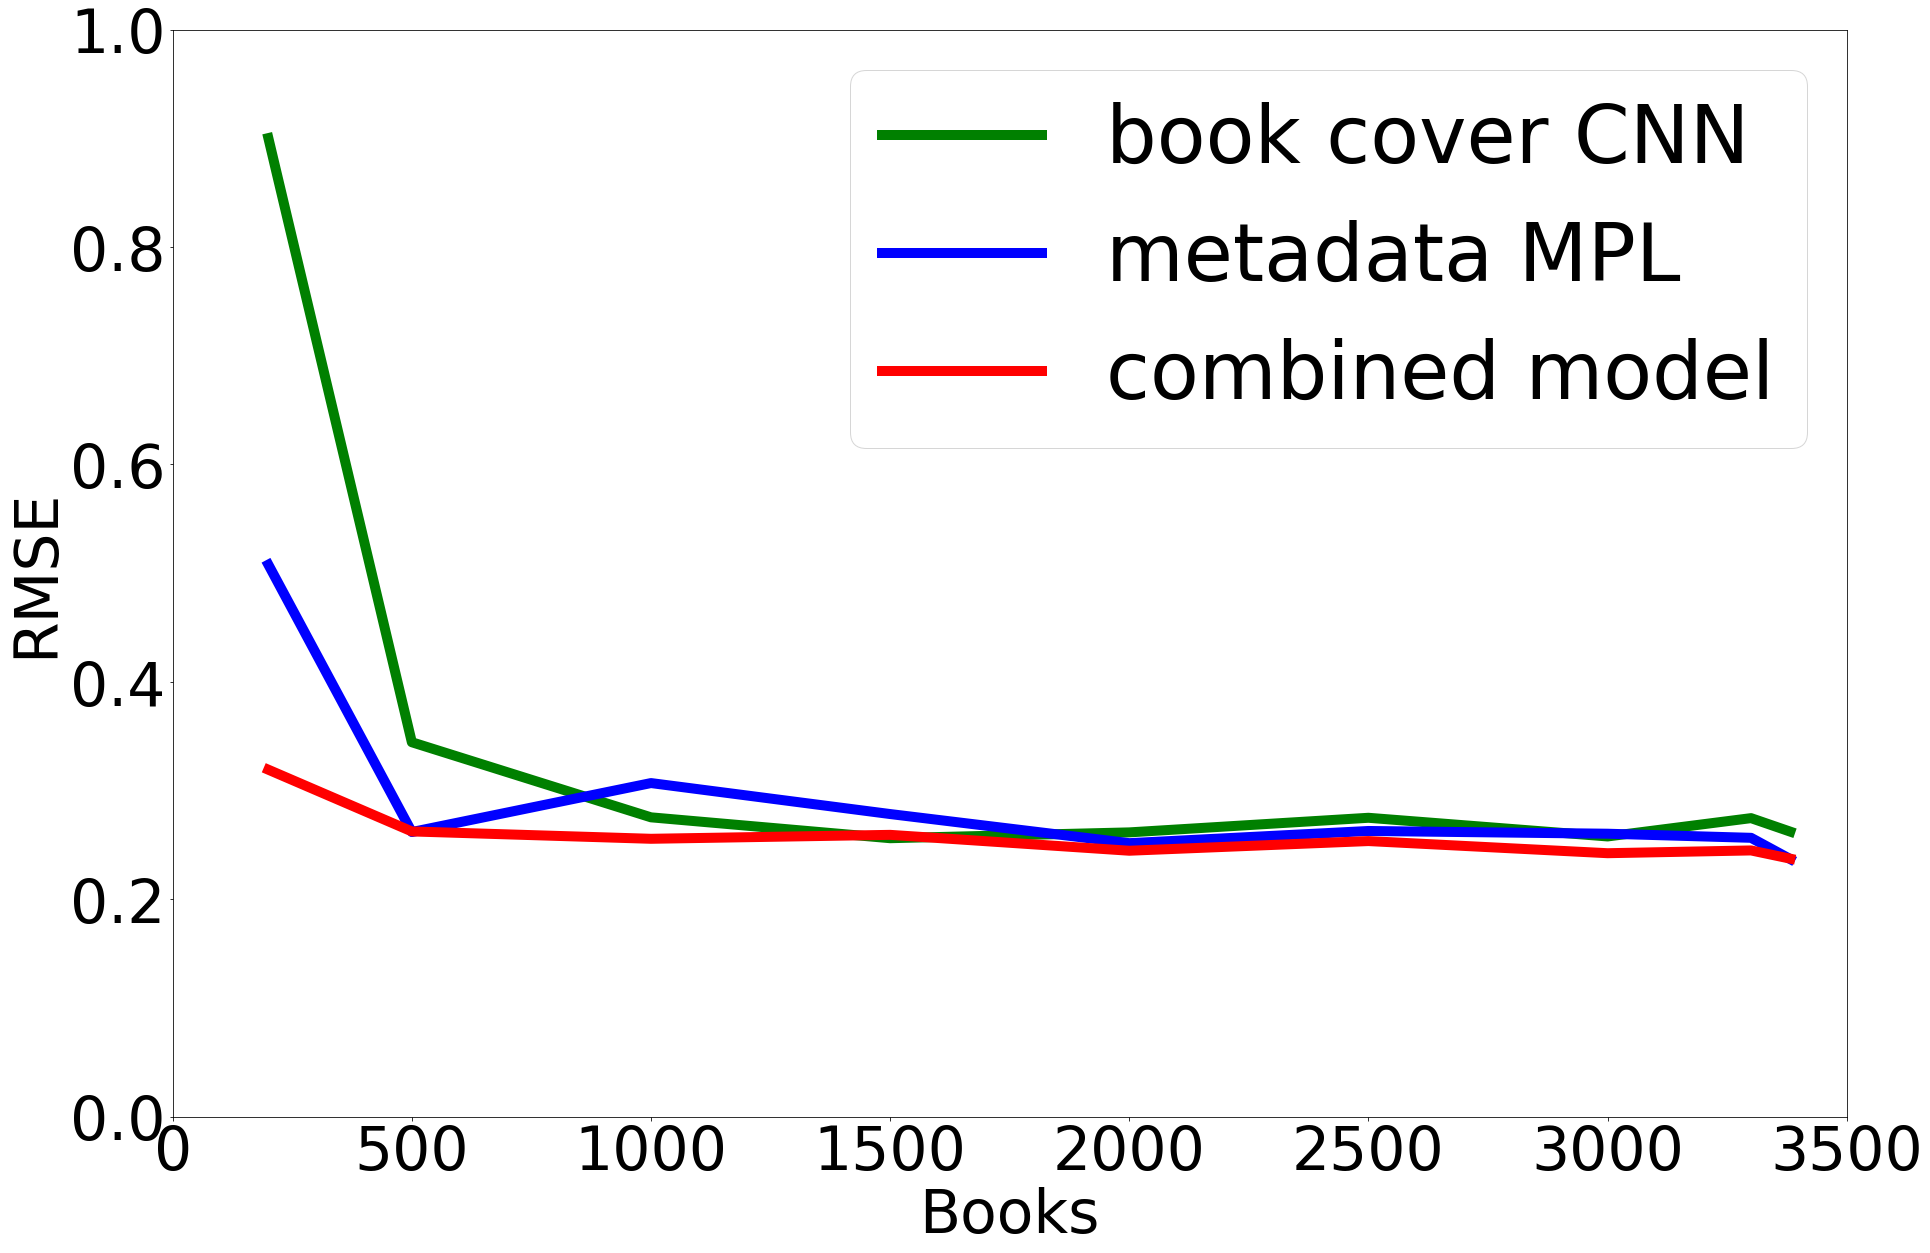

In [23]:
plt.figure(figsize=(30,20))
# fmt_CNN = '[o][-][b]'
# fmt_MLP = '[s][-][r]'
# fmt_Mix = '[*][-][g]'
plt.plot(fullRMSE['n_books'], fullRMSE['image_based'], 'g-o', label='book cover CNN', linewidth=10)
plt.plot(fullRMSE['n_books'], fullRMSE['data_based'], 'b-o', label='metadata MPL', linewidth=10)
plt.plot(fullRMSE['n_books'], fullRMSE['mixed_model'], 'r-o', label='combined model', linewidth=10)
plt.xlim(0,3500)
plt.ylim(0, 1)

# add labels and save to disk
#plt.title('compare RMSE across models', fontsize=20)
plt.xlabel('Books', fontsize=60)
plt.ylabel('RMSE', fontsize=60)
plt.xticks(fontsize=60)
plt.yticks(fontsize=60)
plt.legend(fontsize=80)
plt.savefig(save_path + r'/fullRMSE.png')

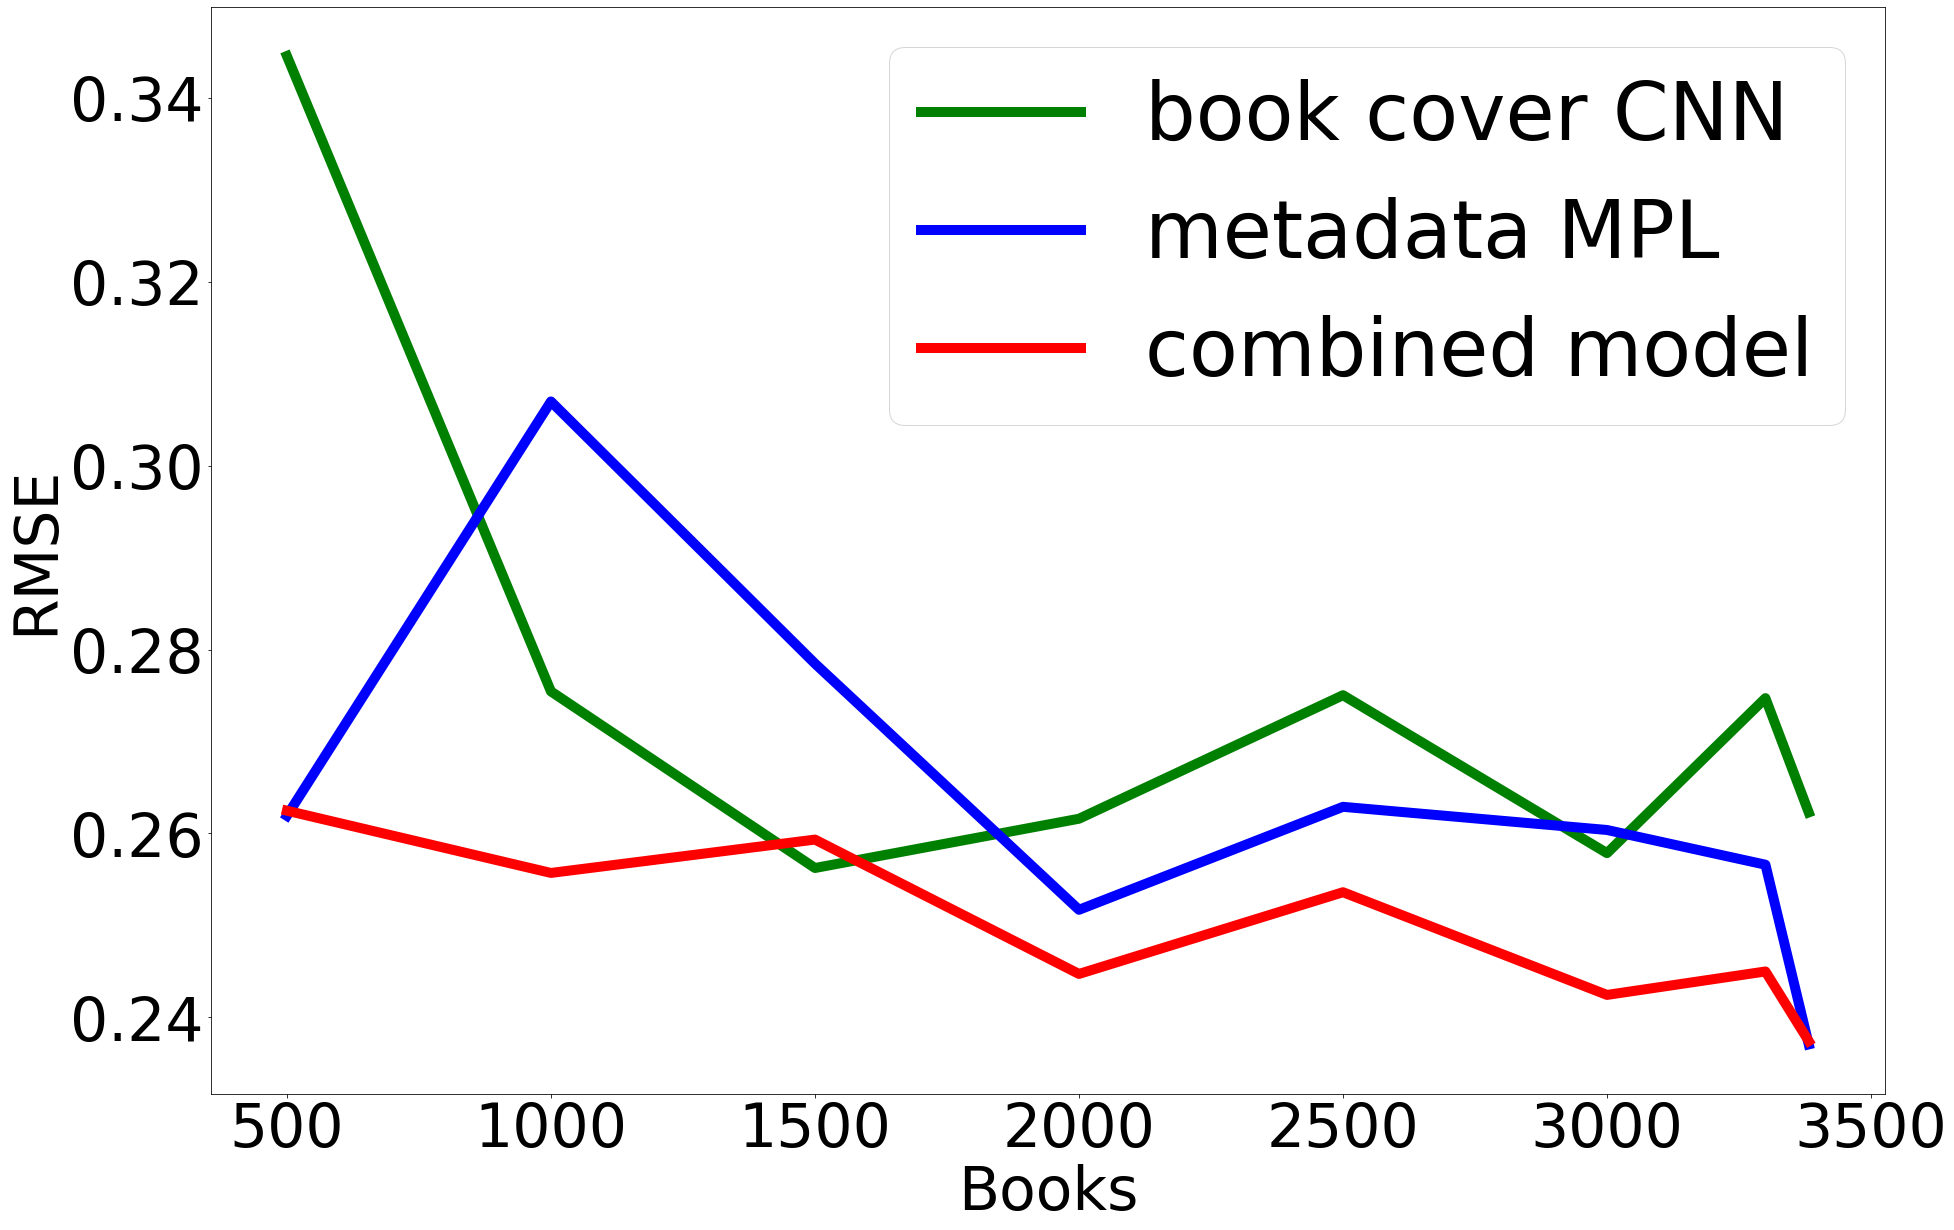

In [22]:
plt.figure(figsize=(30,20))
# fmt_CNN = '[o][-][b]'
# fmt_MLP = '[s][-][r]'
# fmt_Mix = '[*][-][g]'
plt.plot(fullRMSE['n_books'][1:], fullRMSE['image_based'][1:], 'g-o', label='book cover CNN', linewidth=10)
plt.plot(fullRMSE['n_books'][1:], fullRMSE['data_based'][1:], 'b-o', label='metadata MPL', linewidth=10)
plt.plot(fullRMSE['n_books'][1:], fullRMSE['mixed_model'][1:], 'r-o', label='combined model', linewidth=10)
#plt.xlim(0,3500)
#plt.ylim(0, 0.5)

# add labels and save to disk
#plt.title('compare RMSE across models', fontsize=20)
plt.xlabel('Books', fontsize=60)
plt.ylabel('RMSE', fontsize=60)
plt.xticks(fontsize=60)
plt.yticks(fontsize=60)
plt.legend(fontsize=80)
plt.savefig(save_path + r'/fullRMSE_zoomed.png')